# Задача 7. Нейронные сети

* **Дедлайн**: 28.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
- [x] Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- [x] Использовать CrossEntropyLoss и L2-регуляризацию.
- [x] Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- [ ] * (**+2 балла**) Добавить Batch normalization.
- [ ] * (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- [ ] * (**+1 балл**) Также реализовать оптимизатор Adam.


**Выполнил**: Азим Мурадов

**Университет**: СПбГУ

**Группа**: 22.Б11-мм

В качестве датасета будет использован **MNIST_784** - база данных рукописных цифр MNIST с 784 признаками.

**Источник**: https://www.openml.org/search?type=data&sort=nr_of_likes&status=active&id=554

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def load_mnist_data():
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

    X = X.astype(np.float32) / 255.0
    y = y.astype(np.int64)

    # train/val/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

## Реализуем классы, необходимые для построения сети

In [2]:
class FullyConnectedLayer:
    def __init__(self, in_features, out_features):
        self.w = np.random.randn(in_features, out_features) * 0.01
        self.b = np.zeros(out_features)
        self.dw = None
        self.db = None
        self.x = None

    def forward(self, x):
        self.x = x
        return x @ self.w + self.b

    def backward(self, grad_output):
        self.dw = self.x.T @ grad_output
        self.db = np.sum(grad_output, axis=0)
        grad_input = grad_output @ self.w.T
        return grad_input

    def step(self, lr, l2_reg=0.0):
        self.w -= lr * (self.dw + l2_reg * self.w)
        self.b -= lr * self.db

In [3]:
class ReluLayer:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask

    def backward(self, grad_output):
        return grad_output * self.mask

    def step(self, _lr, _l2_reg):
        # No parameters to update in ReLU layer
        pass

In [4]:
class Net:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.layers = [
            FullyConnectedLayer(input_dim, hidden_dim),
            ReluLayer(),
            FullyConnectedLayer(hidden_dim, output_dim),
        ]

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def step(self, lr, l2_reg=0.0):
        for layer in self.layers:
            layer.step(lr, l2_reg)

In [5]:
class CrossEntropyLoss:
    def __init__(self):
        self.logits = None
        self.labels = None

    def forward(self, logits, labels):
        self.logits = logits
        self.labels = labels
        # logits: [batch, num_classes], labels: [batch]
        logits_stable = logits - np.max(logits, axis=1, keepdims=True)
        exp_logits = np.exp(logits_stable)
        probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        self.probs = probs
        N = logits.shape[0]
        loss = -np.log(probs[np.arange(N), labels] + 1e-9).mean()
        return loss

    def backward(self):
        N = self.logits.shape[0]
        grad = self.probs.copy()
        grad[np.arange(N), self.labels] -= 1
        grad = grad / N
        return grad

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist_data()

input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 10

## Проверим корректность вычисления градиентов с помощью разностной оценки

In [7]:
def grad_check_full(model: Net, loss_fn, X, y, eps=1e-5, tol=1e-4):
    logits = model.forward(X)
    loss_fn.forward(logits, y)
    grad = loss_fn.backward()
    model.backward(grad)

    fc1, _, fc2 = model.layers

    params = [fc1.w, fc1.b, fc2.w, fc2.b]
    grads = [fc1.dw, fc1.db, fc2.dw, fc2.db]
    names = ["fc1.w", "fc1.b", "fc2.w", "fc2.b"]

    for param, grad_analytical, name in zip(params, grads, names):
        num_grad = np.zeros_like(param)
        it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            orig = param[idx]
            param[idx] = orig + eps
            plus = loss_fn.forward(model.forward(X), y)
            param[idx] = orig - eps
            minus = loss_fn.forward(model.forward(X), y)
            param[idx] = orig
            num_grad[idx] = (plus - minus) / (2 * eps)
            it.iternext()

        rel_error = np.abs(grad_analytical - num_grad) / (np.abs(grad_analytical) + np.abs(num_grad) + 1e-8)
        max_error = np.max(rel_error)

        print(f"Max relative error for {name}: {max_error:.2e}")
        if max_error < tol:
            print(f"Gradient check for {name} passed!")
        else:
            print(f"Gradient check for {name} failed!")

In [8]:
np.random.seed(42)
model_check = Net(input_dim, hidden_dim, output_dim)
loss_fn_check = CrossEntropyLoss()
grad_check_full(model_check, loss_fn_check, X_train[:5], y_train[:5])

Max relative error for fc1.w: 5.25e-05
Gradient check for fc1.w passed!
Max relative error for fc1.b: 5.27e-08
Gradient check for fc1.b passed!
Max relative error for fc2.w: 4.83e-08
Gradient check for fc2.w passed!
Max relative error for fc2.b: 5.10e-09
Gradient check for fc2.b passed!


## Обучим модель на тренировочных данных, подберём параметры и проанализируем результаты

In [9]:
def accuracy(logits, labels):
    preds = np.argmax(logits, axis=1)
    return np.mean(preds == labels)

In [10]:
def train(
    model,
    loss_fn,
    X_train, y_train, X_val, y_val,
    epochs=10, batch_size=128, lr=1e-2, l2_reg=0.0,
):
    n_train = X_train.shape[0]
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for _ in range(epochs):
        # Shuffle
        idx = np.random.permutation(n_train)
        X_train, y_train = X_train[idx], y_train[idx]

        # Use batches
        for i in range(0, n_train, batch_size):
            xb = X_train[i:i+batch_size]
            yb = y_train[i:i+batch_size]
            logits = model.forward(xb)
            loss_fn.forward(logits, yb)
            grad = loss_fn.backward()
            model.backward(grad)
            model.step(lr, l2_reg)

        # Metrics
        fc1, _, fc2 = model.layers

        train_logits = model.forward(X_train)
        val_logits = model.forward(X_val)

        train_loss = loss_fn.forward(train_logits, y_train)
        val_loss = loss_fn.forward(val_logits, y_val)
        l2_loss_train = 0.5 * l2_reg * (np.sum(fc1.w ** 2) + np.sum(fc2.w ** 2))
        l2_loss_val = 0.5 * l2_reg * (np.sum(fc1.w ** 2) + np.sum(fc2.w ** 2))
        total_train_loss = train_loss + l2_loss_train
        total_val_loss = val_loss + l2_loss_val

        train_acc = accuracy(train_logits, y_train)
        val_acc = accuracy(val_logits, y_val)

        history['train_loss'].append(total_train_loss)
        history['val_loss'].append(total_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    return history

In [11]:
def grid_search(X_train, y_train, X_val, y_val, input_dim, hidden_dim, output_dim, lr_list, l2_list, epochs=10, batch_size=128):
    results = []
    for lr in lr_list:
        for l2_reg in l2_list:
            model = Net(input_dim, hidden_dim, output_dim)
            loss_fn = CrossEntropyLoss()
            history = train(
                model, loss_fn,
                X_train, y_train, X_val, y_val,
                epochs=epochs, batch_size=batch_size, lr=lr, l2_reg=l2_reg
            )
            best_val_acc = max(history['val_acc'])
            results.append({'lr': lr, 'l2_reg': l2_reg, 'val_acc': best_val_acc})
    return results

In [12]:
lr_list = [0.001, 0.005, 0.01]
l2_list = [0.0, 1e-4, 1e-3]

results = grid_search(
    X_train, y_train, X_val, y_val,
    input_dim, hidden_dim, output_dim,
    lr_list, l2_list,
    epochs=20, batch_size=128,
)

results.sort(key=lambda x: x['val_acc'], reverse=True)
print("\nGrid search results (sorted):")
for res in results:
    print(f"lr={res['lr']}, l2_reg={res['l2_reg']}, val_acc={res['val_acc']:.4f}")


Grid search results (sorted):
lr=0.01, l2_reg=0.001, val_acc=0.9153
lr=0.01, l2_reg=0.0001, val_acc=0.9147
lr=0.01, l2_reg=0.0, val_acc=0.9139
lr=0.005, l2_reg=0.001, val_acc=0.8974
lr=0.005, l2_reg=0.0, val_acc=0.8970
lr=0.005, l2_reg=0.0001, val_acc=0.8966
lr=0.001, l2_reg=0.0001, val_acc=0.7644
lr=0.001, l2_reg=0.0, val_acc=0.7613
lr=0.001, l2_reg=0.001, val_acc=0.7584


Выберем lr = 0.01 и l2_reg = 0.0. l2_reg не сильно повлиял на результат, поэтому выгоднее его прировнять к нулю.

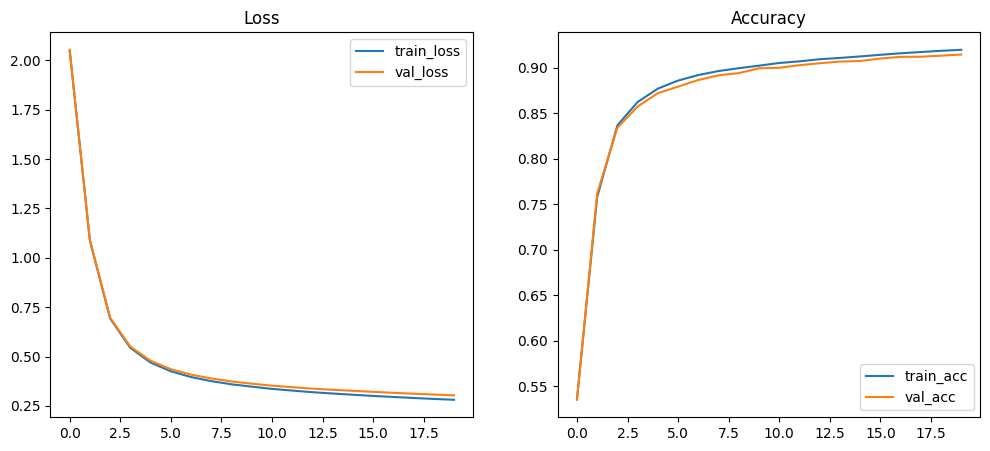

In [13]:
model = Net(input_dim, hidden_dim, output_dim)
loss_fn = CrossEntropyLoss()

history = train(
    model,
    loss_fn,
    X_train, y_train, X_val, y_val,
    epochs=20, batch_size=128, lr=0.01, l2_reg=0.0,
)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

Присутствует незначительное (не критичное) переобучение. В остальном, графики соответствуют качественному обучению.

In [14]:
test_logits = model.forward(X_test)
test_acc = accuracy(test_logits, y_test)

print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.9239
